In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split
sns.set()

Загрузка данных первого сета.

In [155]:
red_wine_data = pd.read_csv('winequality-red.csv', delimiter=';')
white_wine_data = pd.read_csv('winequality-white.csv', delimiter=';')
wines = red_wine_data.append(white_wine_data)
#Смотрим основные параметры.

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [156]:
wines.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.7,0.600,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.60,12.9,6
96,6.8,0.775,0.00,3.0,0.102,8.0,23.0,0.9965,3.45,0.56,10.7,5
97,7.0,0.500,0.25,2.0,0.070,3.0,22.0,0.9963,3.25,0.63,9.2,5
98,7.6,0.900,0.06,2.5,0.079,5.0,10.0,0.9967,3.39,0.56,9.8,5


Удалим повторяющиеся записи

In [157]:
# first_data.drop_duplicates("Player", inplace=True)
# first_data["Player"].value_counts()

Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [158]:
wines.count()

fixed acidity           6497
volatile acidity        6497
citric acid             6497
residual sugar          6497
chlorides               6497
free sulfur dioxide     6497
total sulfur dioxide    6497
density                 6497
pH                      6497
sulphates               6497
alcohol                 6497
quality                 6497
dtype: int64

В процентном соотношении.

In [159]:
for col in wines.columns:
    pct_missing = np.mean(wines[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {wines[col].min()}     max:{wines[col].max()}')

fixed acidity - 0.0     min: 3.8     max:15.9
volatile acidity - 0.0     min: 0.08     max:1.58
citric acid - 0.0     min: 0.0     max:1.66
residual sugar - 0.0     min: 0.6     max:65.8
chlorides - 0.0     min: 0.009000000000000001     max:0.611
free sulfur dioxide - 0.0     min: 1.0     max:289.0
total sulfur dioxide - 0.0     min: 6.0     max:440.0
density - 0.0     min: 0.98711     max:1.03898
pH - 0.0     min: 2.72     max:4.01
sulphates - 0.0     min: 0.22     max:2.0
alcohol - 0.0     min: 8.0     max:14.9
quality - 0.0     min: 3     max:9


Пропущенных значений нет, как и заявлялось в описании. Странность есть в минимальном значении столбца "chlorides", исправим:

In [160]:
wines["chlorides"] = round(wines["chlorides"], 3)

In [161]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Из таблицы резко выбиваются значения "free sulfur dioxide":289 и "total sulfur dioxide": 400. Проверим не ошибочные ли это данные.

<AxesSubplot:>

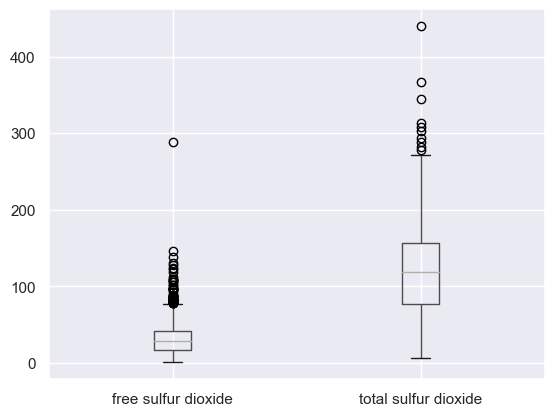

In [162]:
wines.boxplot(column=["free sulfur dioxide", "total sulfur dioxide"])

Можно предположить что значение столбца "free sulfur dioxide" значением около 300 может быть ошибочным, как и значение "total sulfur dioxide" более 400. Посмотрим на эти записи ближе.

In [163]:
wines[wines["free sulfur dioxide"] > 200]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4745,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


Как видно это оказывается одна запись. И хоть это и выбросы  но их объяснение просто: сверх высокая кислотность привод к минимальной оценке. Эти данные не являются ошибочными.

In [164]:
# sns.pairplot(wines);

In [165]:
# corr_matrix = wines.corr()
# sns.heatmap(corr_matrix);

На таблицах корреляции, видно интересную картину, во первых корреляция присутствует в столбцах отвечающих за "кислость" вина, в принципе это не удивительно, чем больше сахара тем меньше кислости, и наоборот. Но есть один параметр напрямую коррелирующий с оценкой от экспертов, этот столбец "alcohol".

Добавим столбцы долей зависимых величин.

In [166]:
wines["free sulfur dioxide share"] = round((wines["free sulfur dioxide"] / wines["total sulfur dioxide"]) * 100)
wines["volatile acidity share"] = round((wines["volatile acidity"] / wines["fixed acidity"]) * 100)

Довольно много столбцов имеют распределение близкое к нормальному, по этому постараемся применить стандартный скалер.

In [167]:
scaler = preprocessing.MinMaxScaler()

target = wines["quality"]
wines.drop(columns=["quality"],inplace=True)

columns = wines.columns
wines[columns] = scaler.fit_transform(wines[columns])

print(wines.shape)

X_train, X_test_val, y_train, y_test_val = train_test_split(wines, target, test_size=0.6)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, stratify=target, test_size=0.5)
X_train

(6497, 13)


ValueError: Found input variables with inconsistent numbers of samples: [3899, 6497]